In [ ]:
# load necessary libraries for network anaylysis
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os as os
import powerlaw
import mygene
import matplotlib.patches as mpatches

import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# loading the edgelist of turquoise module
file_path = r"C:\Users\Dhruv\Downloads\115650_fpkm_001_extracted_networks_edges_red.txt"

data = pd.read_csv(file_path,sep='\t')

#print the head
print(data.head())
data.rename(columns={data.columns[0]: "gene1", data.columns[1]: "gene2", data.columns[2]: "correlation"}, inplace=True)
print(data.head())


#removing the version of the ensembl ids solater their gene symbol can be mapped using mygene api
# Remove version numbers from gene1 and gene2 columns
data['gene1'] = data['gene1'].str.split('.').str[0]
data['gene2'] = data['gene2'].str.split('.').str[0]
data.head()


             fromNode              toNode    weight   direction  fromAltName  \
0  ENSG00000021776.10  ENSG00000091039.16  0.105329  undirected          NaN   
1  ENSG00000021776.10   ENSG00000151151.5  0.114666  undirected          NaN   
2  ENSG00000058063.15  ENSG00000171988.17  0.113267  undirected          NaN   
3  ENSG00000073008.14   ENSG00000279095.1  0.135181  undirected          NaN   
4  ENSG00000080824.18  ENSG00000120694.19  0.204119  undirected          NaN   

   toAltName  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
                gene1               gene2  correlation   direction  \
0  ENSG00000021776.10  ENSG00000091039.16     0.105329  undirected   
1  ENSG00000021776.10   ENSG00000151151.5     0.114666  undirected   
2  ENSG00000058063.15  ENSG00000171988.17     0.113267  undirected   
3  ENSG00000073008.14   ENSG00000279095.1     0.135181  undirected   
4  ENSG00000080824.18  ENSG00000120694.19     0.204119  undirected   

   fromA

,gene1,gene2,correlation,direction,fromAltName,toAltName
0,ENSG00000021776,ENSG00000091039,0.105329,undirected,NaN,NaN
1,ENSG00000021776,ENSG00000151151,0.114666,undirected,NaN,NaN
2,ENSG00000058063,ENSG00000171988,0.113267,undirected,NaN,NaN
3,ENSG00000073008,ENSG00000279095,0.135181,undirected,NaN,NaN
4,ENSG00000080824,ENSG00000120694,0.204119,undirected,NaN,NaN


In [ ]:
#creating a network object

G = nx.Graph()
for _, row in data.iterrows():
    G.add_edge(row['gene1'], row['gene2'], weight=row['correlation'])

# Step 1: Convert all Ensembl IDs to gene symbols
all_nodes = list(G.nodes())

mg = mygene.MyGeneInfo()
query_result = mg.querymany(all_nodes, scopes='ensembl.gene', fields='symbol', species='human')

# Step 2: Build mapping dictionary
id_to_symbol = {item['query']: item.get('symbol', item['query']) for item in query_result}

# Step 3: Relabel nodes in the main graph
nx.relabel_nodes(G, id_to_symbol, copy=False)

# Step 4: Compute degree in the renamed graph
degree_dict = dict(G.degree())
degree_df = pd.DataFrame(degree_dict.items(), columns=['Node', 'Degree'])
degree_df = degree_df.sort_values(by='Degree', ascending=False)

# Step 5: Save all and top 25
base_path = r"C:\Users\Dhruv\Documents"
degree_df.to_csv(os.path.join(base_path, "all_nodes_by_degree.csv"), index=False, sep='\t', encoding='utf-8')
print("All nodes saved to all_nodes_by_degree.csv")

top_25_df = degree_df.head(25)
top_25_df.to_csv(os.path.join(base_path, "top_25_nodes_by_degree.csv"), index=False, sep='\t', encoding='utf-8')
print("Top 25 nodes saved to top_25_nodes_by_degree.csv")


# Step 6: Extract subgraph
top_25_nodes = list(top_25_df['Node'])
subgraph = G.subgraph(top_25_nodes).copy()



Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


All nodes saved to all_nodes_by_degree.csv
Top 25 nodes saved to top_25_nodes_by_degree.csv


In [ ]:
#extracting the first neighbours
!pip install openpyxl

# Step 1: Extract first neighbors of top 25 genes
neighbor_dict = {}

for node in top_25_nodes:
    neighbors = list(G.neighbors(node))
    neighbor_dict[node] = neighbors

# Step 2: Convert to DataFrame (column-wise structure)
max_length = max(len(neighbors) for neighbors in neighbor_dict.values())
df_neighbors = pd.DataFrame({k: v + [''] * (max_length - len(v)) for k, v in neighbor_dict.items()})

# Step 3: Save to CSV and Excel
csv_path = r"C:\Users\Dhruv\Documents\red_output\neighbours.csv"
xlsx_path = r"C:\Users\Dhruv\Documents\red_output\neighbours.xlsx"

df_neighbors.to_csv(csv_path, index=False)
df_neighbors.to_excel(xlsx_path, index=False)

In [ ]:
from collections import Counter

# Step 1: Extract neighbors
neighbor_dict = {node: set(G.neighbors(node)) for node in top_25_nodes}

# Step 2: Flatten and count all neighbors
all_neighbors_flat = [neighbor for neighbors in neighbor_dict.values() for neighbor in neighbors]
neighbor_counts = Counter(all_neighbors_flat)

# Step 3: Common neighbors — appear in all 25 sets
common_neighbors = [node for node, count in neighbor_counts.items() if count == len(top_25_nodes)]

# Step 4: Unique neighbors — appear in only 1 set
unique_neighbors = [node for node, count in neighbor_counts.items() if count == 1]

# Step 5: Save common and unique neighbors
df_common = pd.DataFrame({'common_neighbors': common_neighbors})
df_unique = pd.DataFrame({'unique_neighbors': unique_neighbors})

# File paths
common_path_csv = r"C:\Users\Dhruv\Documents\red_output\top_25_gene_common_neighbours.csv"
unique_path_csv = r"C:\Users\Dhruv\Documents\red_output\top_25_gene_unique_neighbours.csv"

common_path_xlsx = common_path_csv.replace(".csv", ".xlsx")
unique_path_xlsx = unique_path_csv.replace(".csv", ".xlsx")

# Save
df_common.to_csv(common_path_csv, index=False)
df_common.to_excel(common_path_xlsx, index=False)

df_unique.to_csv(unique_path_csv, index=False)
df_unique.to_excel(unique_path_xlsx, index=False)

Calculating best minimal value for power law fit
Power-law exponent (alpha): 6.593980758420627
Minimum value for power-law behavior (xmin): 6.0
Log-likelihood ratio (R) comparing power-law vs. exponential: 0.4382017389123931, p-value: 0.3717429131579255


c:\Users\Dhruv\anaconda3\Lib\site-packages\powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Log-likelihood ratio (R) comparing power-law vs. lognormal: -0.06739598510816168, p-value: 0.3085300252606815


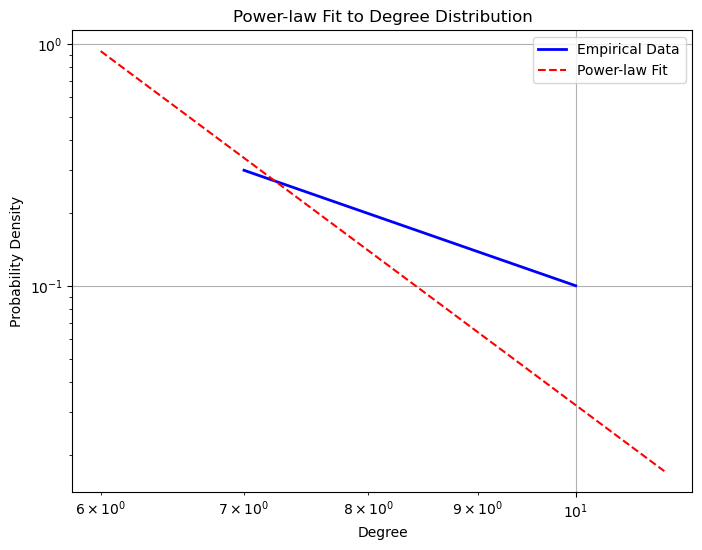

In [ ]:
##testing for power law


# Compute node degrees
degree_sequence = [deg for _, deg in G.degree()]

# Fit power-law distribution
fit = powerlaw.Fit(degree_sequence)

# Print power-law fit parameters
print(f"Power-law exponent (alpha): {fit.power_law.alpha}")
print(f"Minimum value for power-law behavior (xmin): {fit.power_law.xmin}")

# Compare power-law with exponential and lognormal distributions
R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Log-likelihood ratio (R) comparing power-law vs. exponential: {R}, p-value: {p}")

R_ln, p_ln = fit.distribution_compare('power_law', 'lognormal')
print(f"Log-likelihood ratio (R) comparing power-law vs. lognormal: {R_ln}, p-value: {p_ln}")

# Plot degree distribution with power-law fit
plt.figure(figsize=(8, 6))
fit.plot_pdf(label="Empirical Data", color='blue', linewidth=2)
fit.power_law.plot_pdf(label="Power-law Fit", color='red', linestyle="--")
plt.xlabel("Degree")
plt.ylabel("Probability Density")
plt.title("Power-law Fit to Degree Distribution")
plt.legend()
plt.grid(True)
plt.show()


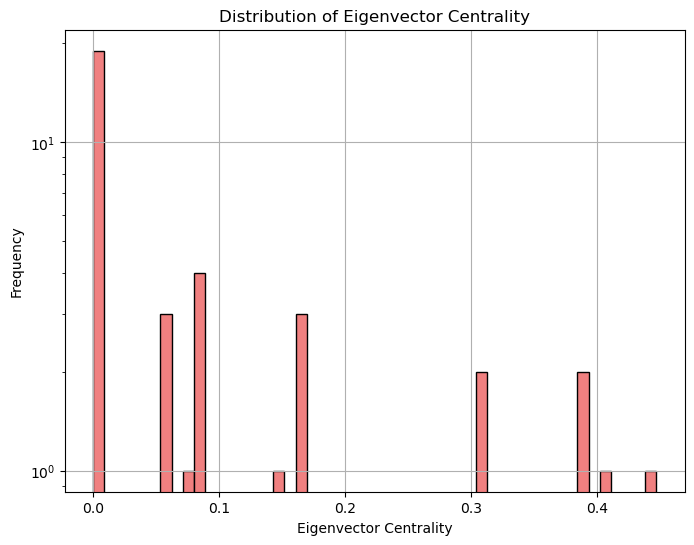

Eigenvector centrality analysis completed. Files saved in: C:\Users\Dhruv\Documents\red_output\eigenvector_centrality\eigenvector


In [ ]:
#computing eigenvector centrality
base_folder = r"C:\Users\Dhruv\Documents\red_output\eigenvector_centrality"

# Create subfolder for eigenvector centrality
eigenvector_folder = os.path.join(base_folder, "eigenvector")
os.makedirs(eigenvector_folder, exist_ok=True)


# Compute Eigenvector Centrality
eigenvector = nx.eigenvector_centrality(G, max_iter=1000)

# Convert to DataFrame
eigenvector_df = pd.DataFrame(eigenvector.items(), columns=['Node', 'Eigenvector Centrality'])
eigenvector_df = eigenvector_df.sort_values(by='Eigenvector Centrality', ascending=False)

# Save full Eigenvector Centrality values
eigenvector_df.to_csv(os.path.join(eigenvector_folder, "eigenvector_centrality.csv"), index=False,sep='\t',encoding='utf-8')

# Save top 25 nodes by Eigenvector Centrality
top_25_df = eigenvector_df.head(25)
top_25_df.to_csv(os.path.join(eigenvector_folder, "top_25_eigenvector.csv"), index=False,sep='\t',encoding='utf-8')

# Plot Eigenvector Centrality distribution
plt.figure(figsize=(8, 6))
plt.hist(eigenvector_df['Eigenvector Centrality'], bins=50, color='lightcoral', edgecolor='black')
plt.xlabel("Eigenvector Centrality")
plt.ylabel("Frequency")
plt.title("Distribution of Eigenvector Centrality")
plt.yscale("log")  # Log scale for better visualization
plt.grid()

# Save plot
plt.savefig(os.path.join(eigenvector_folder, "eigenvector_distribution.png"))
plt.show()

print("Eigenvector centrality analysis completed. Files saved in:", eigenvector_folder)


C:\Users\Dhruv\AppData\Local\Temp\ipykernel_161440\283027775.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", num_communities)
c:\Users\Dhruv\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


Community information saved to: C:\Users\Dhruv\Documents\red_output\lowain_algorithm\community\louvain_communities.csv


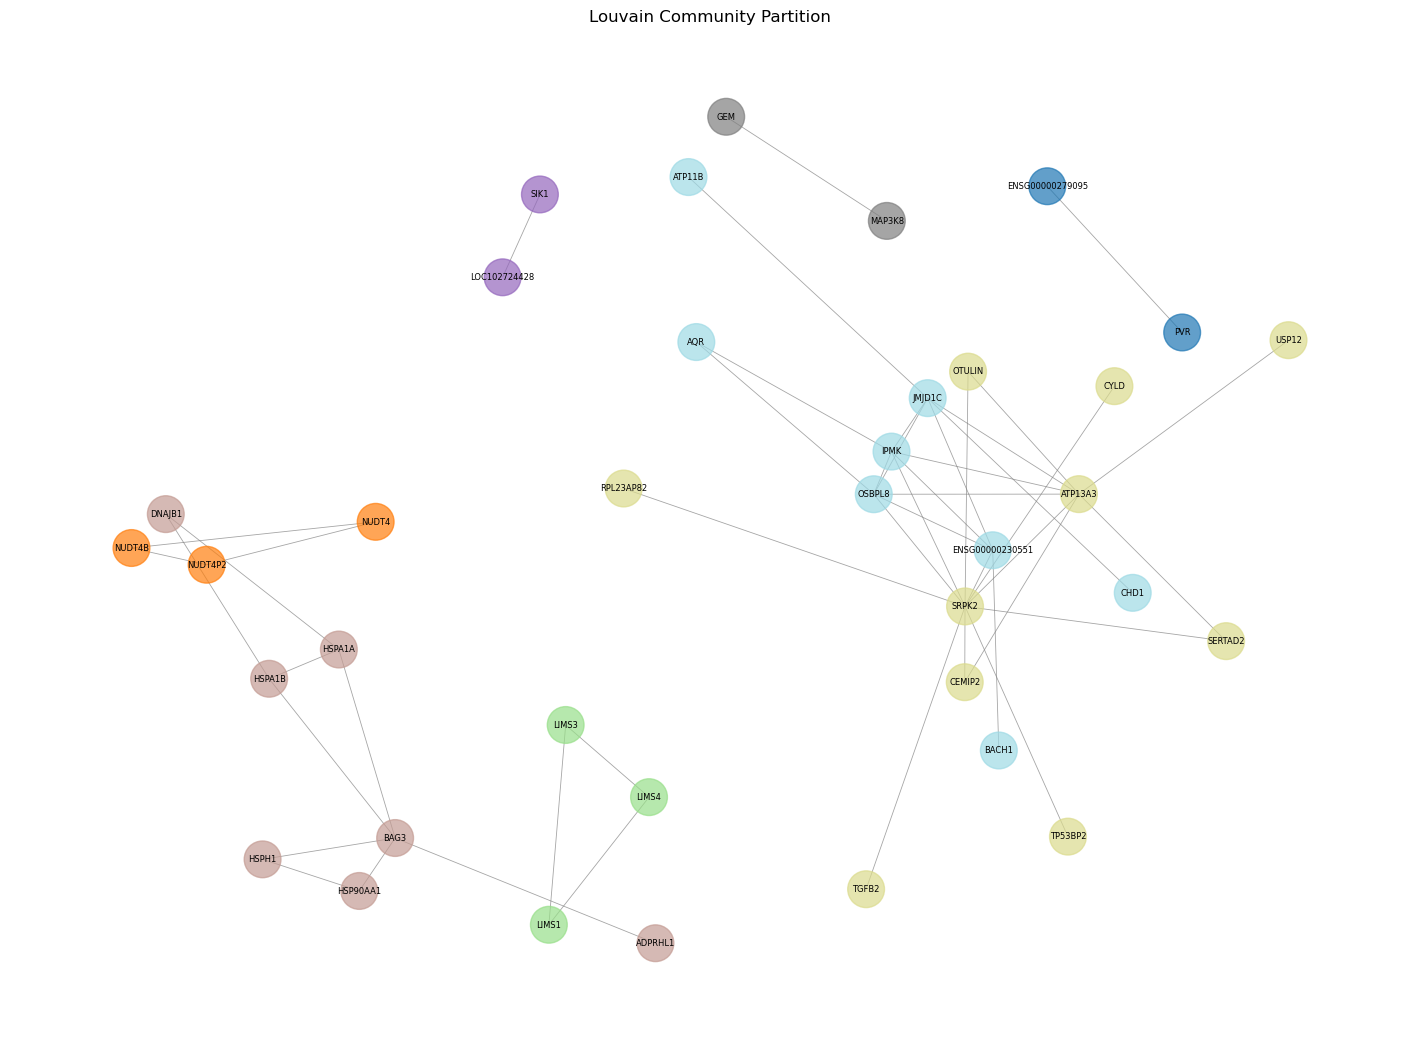

Community plot saved to: C:\Users\Dhruv\Documents\red_output\lowain_algorithm\community\louvain_community_plot.svg


In [ ]:
#community analysis using louvain algorithm
op_folder =r"C:\Users\Dhruv\Documents\red_output\lowain_algorithm"
# Create subfolder for community analysis
community_folder = os.path.join(op_folder, "community")
os.makedirs(community_folder, exist_ok=True)

# Apply Louvain community detection
communities = nx.community.louvain_communities(G, weight='weight',resolution=1, seed=42)

# Create a mapping from node to community index
community_map = {}
for idx, community in enumerate(communities):
    for node in community:
        community_map[node] = idx

# Generate unique colors for each community
num_communities = len(communities)
colors = plt.cm.get_cmap("tab20", num_communities)
community_colors = {i: colors(i) for i in range(num_communities)}

# Create a dictionary with community number as column names
community_dict = {}
for idx, community in enumerate(communities):
    column_name = f"Community {idx+1}"
    community_dict[column_name] = list(community)

# Convert to DataFrame (transposing to align nodes under each column)
community_df = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in community_dict.items()]))

# Save to CSV
csv_path = os.path.join(community_folder, "louvain_communities.csv")
community_df.to_csv(csv_path, index=False, sep='\t', encoding='utf-8')

print(f"Community information saved to: {csv_path}")

### **🔹 Plotting the Communities**
plt.figure(figsize=(14, 10))  # Increase the figure size
pos = nx.spring_layout(G, seed=42, k=0.3)  # Adjust k for more spread out nodes (default k=0.1)


# Assign colors to nodes based on community membership
node_colors = [community_colors[community_map[node]] for node in G.nodes()]

# Draw the network with assigned colors
nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.tab20,
        node_size=700, edge_color='gray', alpha=0.7, width=0.6)  # Adjust node size, alpha, and edge width

# Add node labels
nx.draw_networkx_labels(G, pos, font_size=6, font_color='black')

plt.title("Louvain Community Partition")
svg_path = os.path.join(community_folder, "louvain_community_plot.svg")
plt.savefig(svg_path, format="svg", bbox_inches="tight", dpi=300, transparent=True)
plt.show()

print(f"Community plot saved to: {svg_path}")



In [ ]:
# Get top 25 hub genes by degree
degree_dict = dict(G.degree())
top_25_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:25]

# Map each top hub gene to its community
top25_community_info = {
    "Gene": top_25_nodes,
    "Degree": [degree_dict[node] for node in top_25_nodes],
    "Community": [community_map[node] + 1 for node in top_25_nodes]  # +1 for human-friendly numbering
}

# Create DataFrame and save
top25_df = pd.DataFrame(top25_community_info)
top25_csv_path = os.path.join(community_folder, "top25_hub_genes_community.csv")
top25_df.to_csv(top25_csv_path, index=False,sep='\t', encoding='utf-8')

# Print summary
print("\nTop 25 hub genes and their communities:")
print(top25_df)

print(f"\nTop 25 hub gene community info saved to: {top25_csv_path}")


Top 25 hub genes and their communities:
               Gene  Degree  Community
0             SRPK2      11          7
1           ATP13A3       8          7
2            JMJD1C       6          8
3              IPMK       6          8
4            OSBPL8       6          8
5   ENSG00000230551       5          8
6              BAG3       5          5
7            HSPA1A       3          5
8            HSPA1B       3          5
9           NUDT4P2       2          2
10           NUDT4B       2          2
11            NUDT4       2          2
12            LIMS3       2          3
13            LIMS4       2          3
14            LIMS1       2          3
15          SERTAD2       2          7
16           OTULIN       2          7
17           CEMIP2       2          7
18           DNAJB1       2          5
19            HSPH1       2          5
20         HSP90AA1       2          5
21              AQR       2          8
22  ENSG00000279095       1          1
23            BACH1    

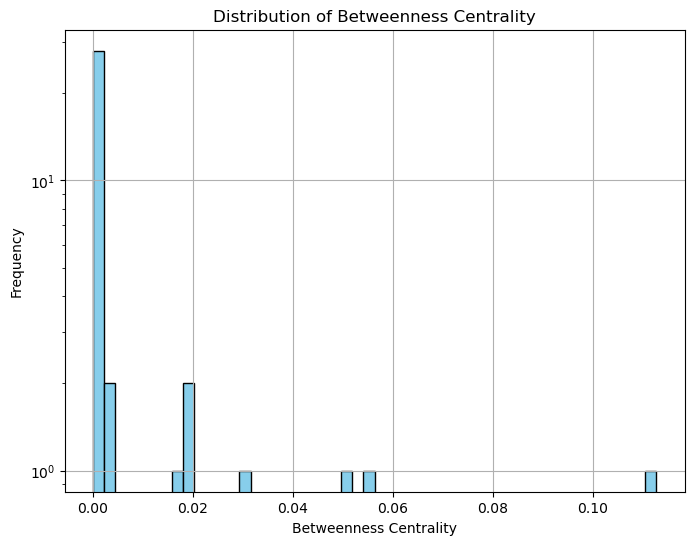

Betweenness centrality analysis completed and files saved.


In [ ]:
##computing betweeness centrality

##taking very long time to run for some reason

# Define the folder path
output_folder = r"C:\Users\Dhruv\Documents\red_output\betweeness_centrality"
# Create the folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Compute betweenness centrality
betweenness = nx.betweenness_centrality(G)

# Convert to DataFrame
betweenness_df = pd.DataFrame(betweenness.items(), columns=['Node', 'Betweenness'])
betweenness_df = betweenness_df.sort_values(by='Betweenness', ascending=False)

# Save full betweenness centrality values
betweenness_df.to_csv(os.path.join(output_folder, "betweenness_centrality.csv"), index=False,sep='\t',encoding='utf-8')

# Save top 25 nodes by betweenness
top_25_df = betweenness_df.head(25)
top_25_df.to_csv(os.path.join(output_folder, "top_25_betweenness.csv"), index=False,sep='\t',encoding='utf-8')

# Plot betweenness centrality distribution
plt.figure(figsize=(8, 6))
plt.hist(betweenness_df['Betweenness'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Betweenness Centrality")
plt.ylabel("Frequency")
plt.title("Distribution of Betweenness Centrality")
plt.yscale("log")  # Log scale to handle skewed distribution
plt.grid()

# Save plot
plt.savefig(os.path.join(output_folder, "betweenness_distribution.png"))
plt.show()

print("Betweenness centrality analysis completed and files saved.")